# Computer Vision - Project
imports

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import h5py
import requests

Constants

In [34]:
#ZIP_PATH = "https://drive.google.com/drive/folders/1jzHYpTwywUYA53nMGHVROSuVO14hEueq?usp=sharing/"
FILE_NAME ="SynthText_train.h5"


In [139]:
import h5py, requests, os
def load_files():    
    #with open(FILE_NAME, "wb") as f:
    #    r = requests.get(ZIP_PATH+FILE_NAME)
    #    f.write(r.content)
    db = h5py.File(FILE_NAME, 'r')
    im_names = list(db['data'].keys())
    im = im_names[0]
    img  = db['data'][im][:]
    #print(img)
    font = db['data'][im].attrs['font']
    #print(font)
    txt = db['data'][im].attrs['txt']
    #print(txt)
    charBB = db['data'][im].attrs['charBB']
    #print(charBB)
    wordBB = db['data'][im].attrs['wordBB']
    #print(wordBB)
    return img, font, txt, charBB, wordBB 

In [145]:
img, font, txt, charBB, wordBB = load_files()
print(wordBB.shape)

(2, 4, 18)


374.43994 500.64325
409
445
357
409
445
357
398
374,445
357,398
T
[b'The' b'the' b'him,' b'the' b'and' b'This' b'with' b'Any' b'From' b'Apr'
 b'This' b'not' b'and' b'core' b'the' b'the' b'all' b'cut']
[b'Titillium Web' b'Titillium Web' b'Titillium Web' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Open Sans' b'Open Sans' b'Open Sans'
 b'Open Sans' b'Open Sans' b'Open Sans' b'Open Sans' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush'
 b'Alex Brush' b'Titillium Web' b'Titillium Web' b'Titillium Web'
 b'Titillium Web' b'Sansation' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Sansation' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Alex Brush'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Titillium Web'
 b'Titillium Web' b'Titillium Web' b'Sansation' b'Sansation' b'Sansation'
 b'Sansation' b'Titillium Web' b'Titillium Web' b'Titillium Web'
 b'Alex Brush' b'Alex Brush' b'Alex Brush' b'Titillium W

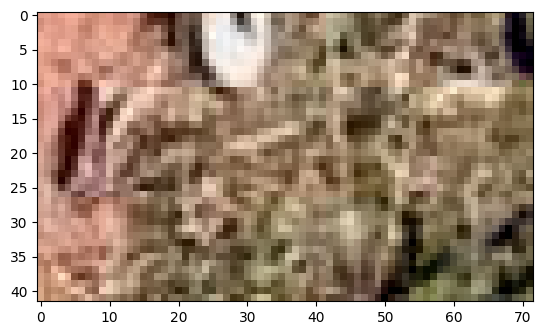

In [159]:
import matplotlib.patches as patches

x = wordBB[0][0][0]
y= wordBB[0][1][0]
print(x,y)
x1 = int(charBB[0,0,0])
x2 = int(charBB[0,1,0])
print(x1)
print(x2)
y1 = int(charBB[1,1,0])
y2 = int(charBB[1,2,0])
print(y1)
x3 = int(charBB[0,2,0])
x4 = int(charBB[0,3,0])
print(x1)
print(x2)
y3 = int(charBB[1,3,0])
y4 = int(charBB[1,0,0])
print(y1)
#rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
print(y2)
# Create figure and axes
#fig, ax = plt.subplots()
# Add the patch to the Axes
#ax.add_patch(rect)
top_left_x = min([x1,x2,x3,x4])
top_left_y = min([y1,y2,y3,y4])
bot_right_x = max([x1,x2,x3,x4])
bot_right_y = max([y1,y2,y3,y4])
print(str(top_left_x)+','+str(bot_right_x))
print(str(top_left_y)+','+str(bot_right_y))
plt.imshow(img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1])
#plt.show()
print(chr(txt[0][0]))
print(txt)
print(font)

In [187]:
def get_bb(img, bbs, indx):
    x1 = int(bbs[0,0,indx])
    x2 = int(bbs[0,1,indx])
    y1 = int(bbs[1,1,indx])
    y2 = int(bbs[1,2,indx])
    x3 = int(bbs[0,2,indx])
    x4 = int(bbs[0,3,indx])
    y3 = int(bbs[1,3,indx])
    y4 = int(bbs[1,0,indx])
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))
    #print(str(top_left_x)+','+str(bot_right_x))
    #print(str(top_left_y)+','+str(bot_right_y))
    return img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

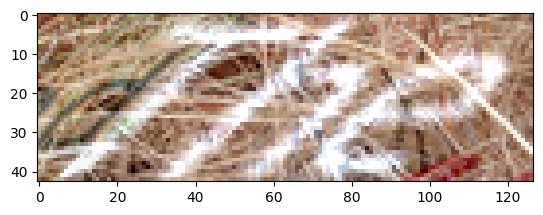

b'The'


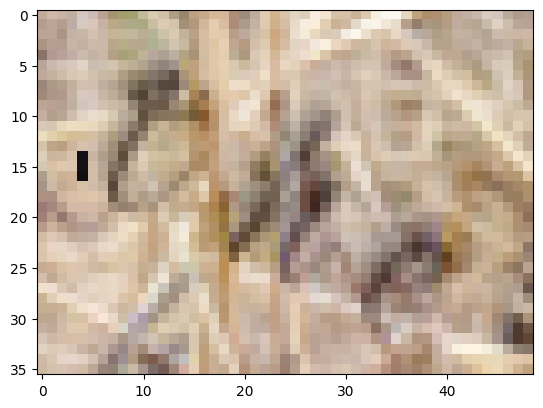

b'the'


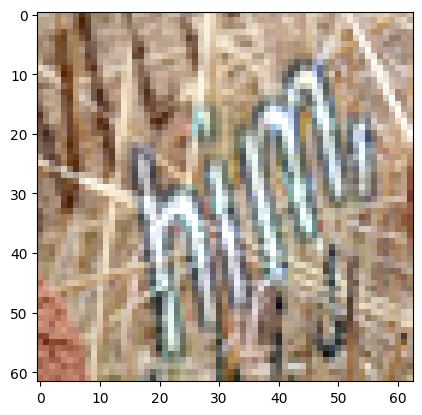

b'him,'


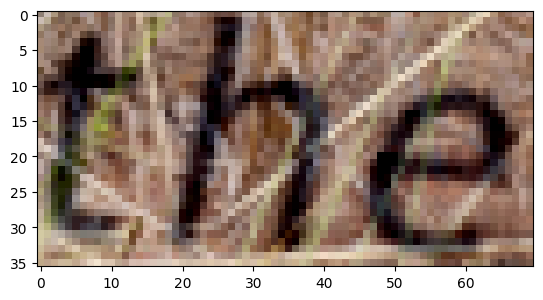

b'the'


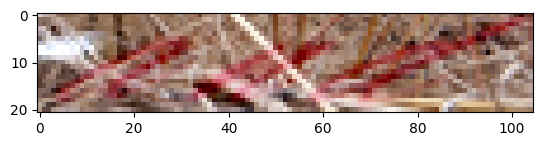

b'and'


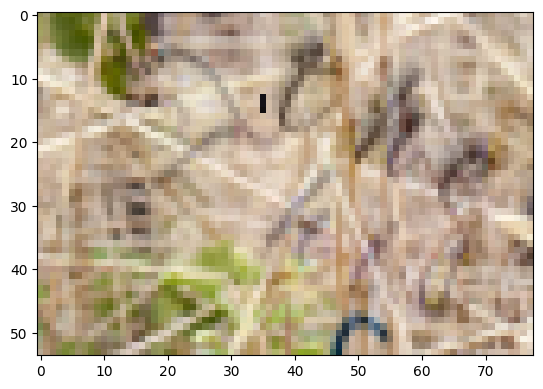

b'This'


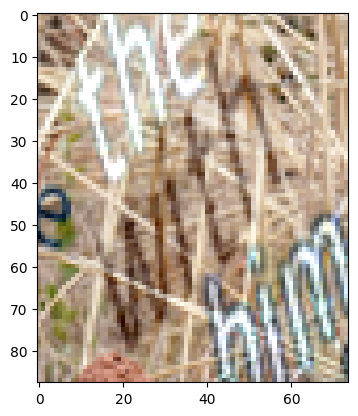

b'with'


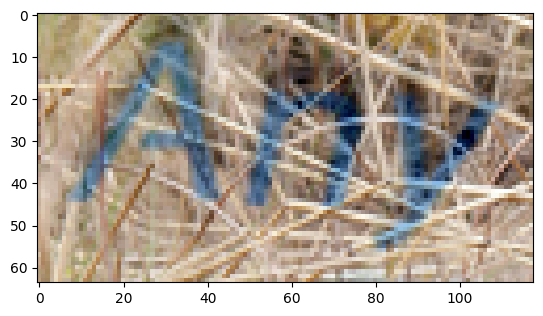

b'Any'


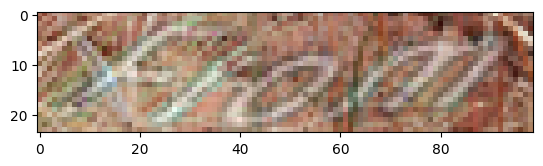

b'From'


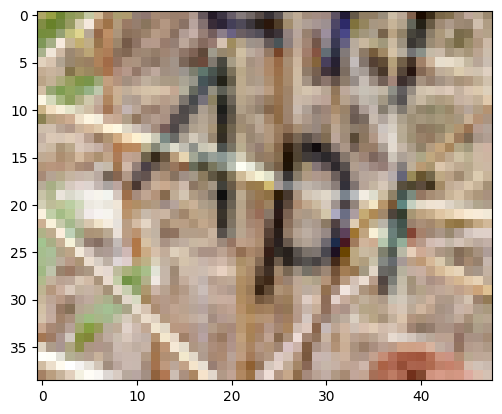

b'Apr'


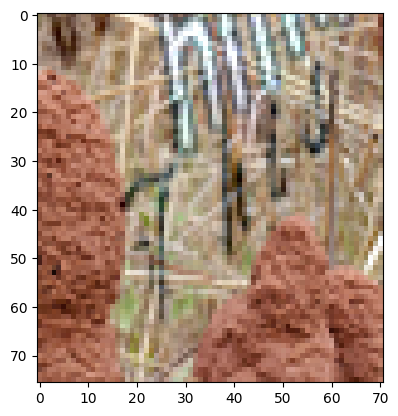

b'This'


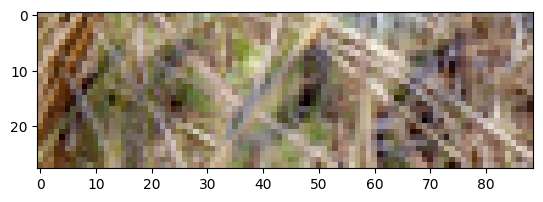

b'not'


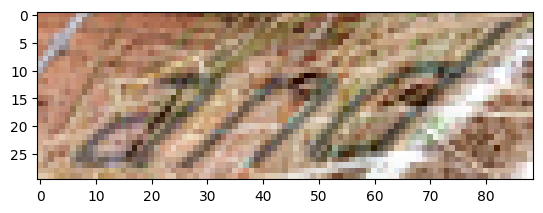

b'and'


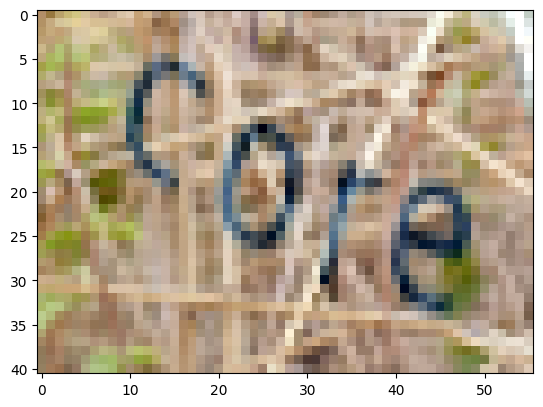

b'core'


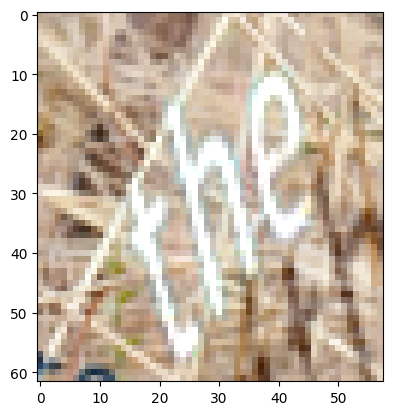

b'the'


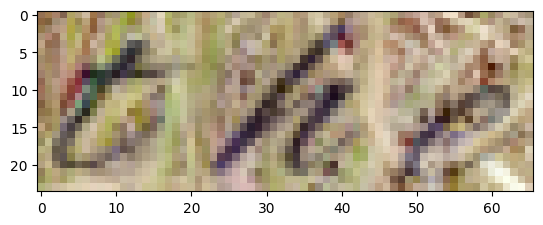

b'the'


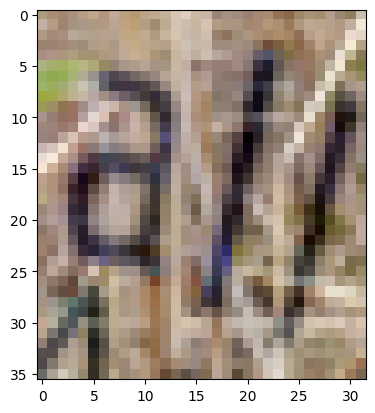

b'all'


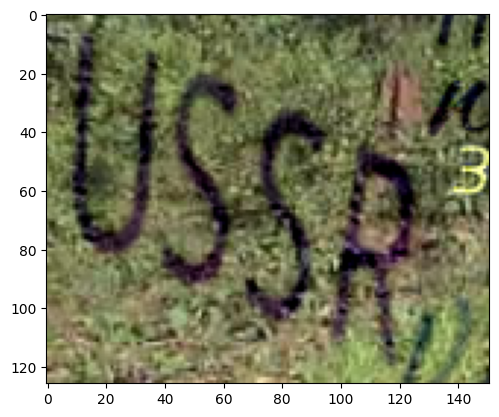

b'USSR'


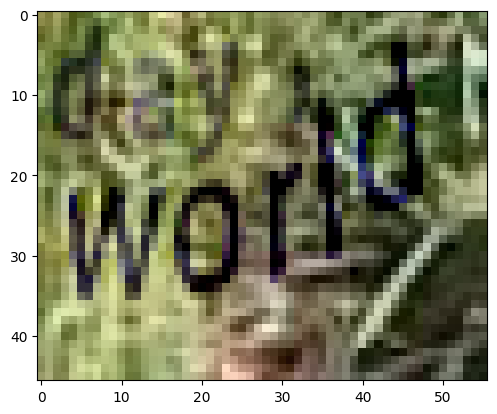

b'world'


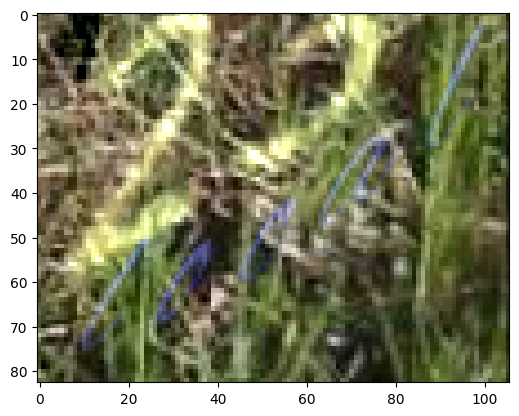

b'local'


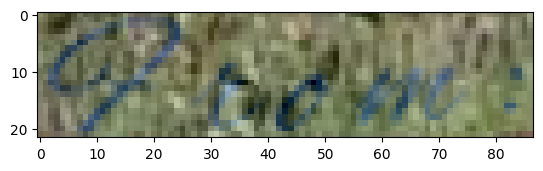

b'From:'


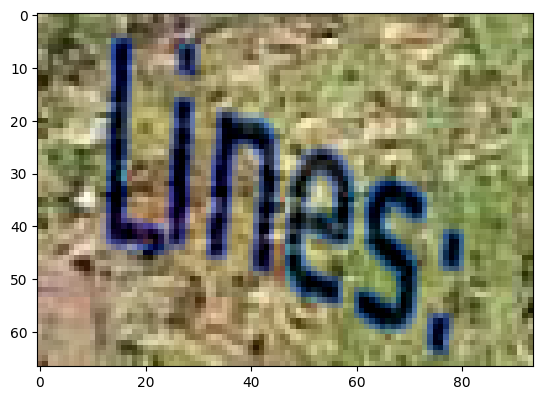

b'Lines:'


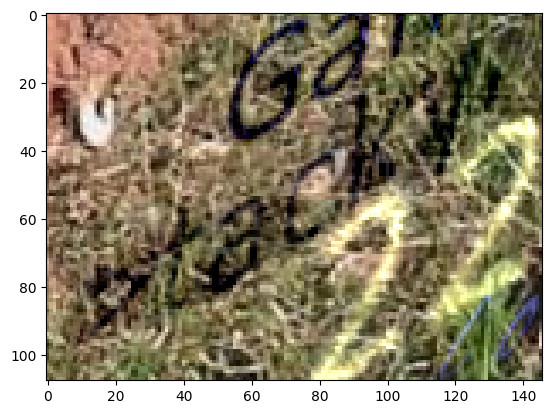

b'>tacky,'


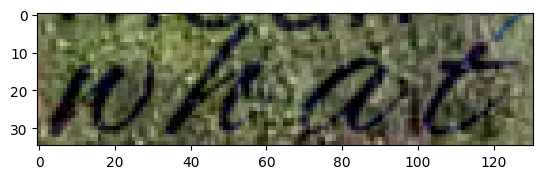

b'what'


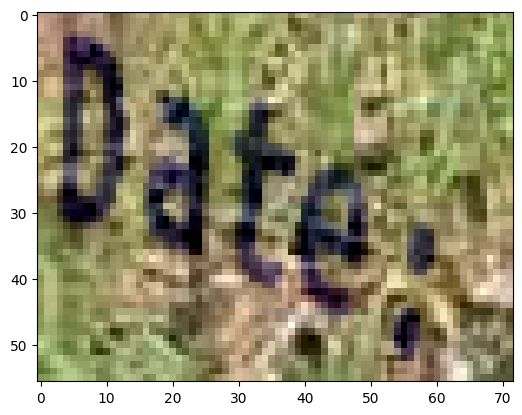

b'Date:'


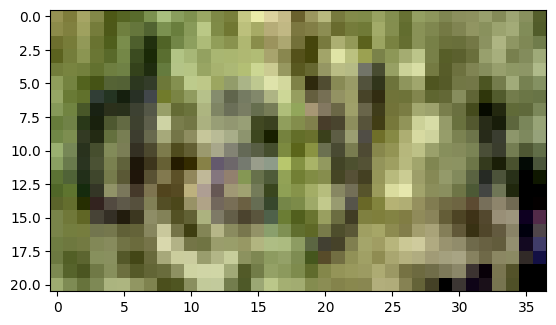

b'day,'


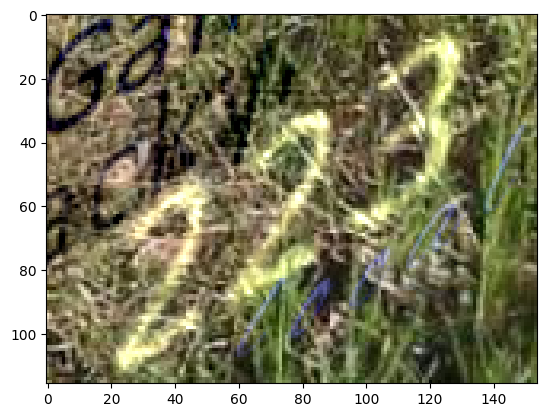

b'223'


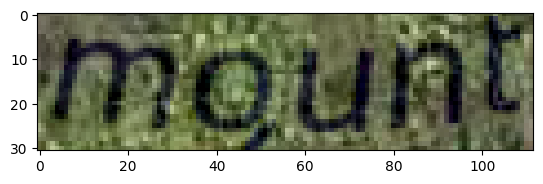

b'mount'


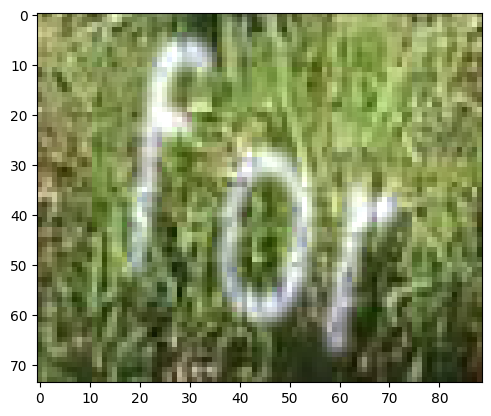

b'for'


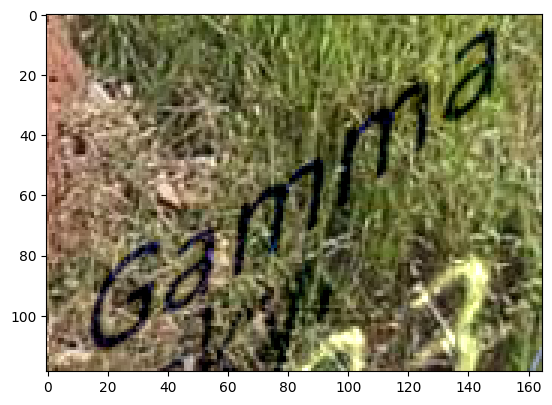

b'Gamma'


IndexError: index 60 is out of bounds for axis 2 with size 60

In [189]:
db = h5py.File(FILE_NAME, 'r')
im_names = list(db['data'].keys())
train_x = []
train_y = []
for i in range(0, len(im_names)-1):
    im = im_names[i]
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    #print(len(fonts))
    #print(len(txts))
    font_indx = 0 
    char_indx = 0
    #print(fonts)
    for j in range(0, len(txts)):
        #print(txts[j])
        cropped = get_bb(img, wordBBs, j)
        plt.imshow(cropped)
        plt.show()
        train_x.append(cropped)
        #print(fonts[font_indx])
        train_y.append(fonts[font_indx])
        font_indx += len(txt[j])
        print(txts[j])
        for k in range(0, len(txts[j])):
            cropped = get_bb(img, charBB, char_indx)
            #plt.imshow(cropped)
            #plt.show()
            train_x.append(cropped)
            #print(fonts[char_indx])
            train_y.append(fonts[char_indx])
            char_indx+=1
    